## CS 109B Final Assignment

# Dual Encoder Transformers for Efficient and Versatile Image Style Transfer

<style>
td, th {
   border: none!important;
}
</style>

| Team member | Email |
| ------------------------- | ------------------------- |
| Nikhil Nayak | nnayak@g.harvard.edu |
| Kareema Batool | kareemabatool@g.harvard.edu |
| Nishtha Sardana | nishthasardana@g.harvard.edu |
| Saket Joshi | saket_joshi@g.harvard.edu |


----------------------------------


# Table of Contents
1. [Problem Statement](#problemstatement)
2. [Baseline Model - Fast Neural Style Transfer architecture](#baselinemodel)
    1. [System Design](#systemdesign)
    2. Conclusions, Future work and interpretation of results (#conclusions)
    3. Dataset Collection (#dataset)
    4. Exploratory Data Analysis (#eda)
    5. Baseline implementataion (#baseline)
3. [Dual Encoder Transformer Model](#dualencodertransformer)
    1. [Architecture Design](#arch2design)
    2. [Dataset collection](#arch2dataset)
    3. Implementation (#arch2implementation)
    4. Testing script (#test)
    5. Demonstration (#demo)

### Corresponding project code and files can also be found at the following github repository -
[https://github.com/saketrule/harvard_CS109B/](https://github.com/saketrule/harvard_CS109B/)


<a name="problemstatement"></a>
## 1.0 - Problem statement - Image style transfer
----------------------------------

Image style transfer is the process of applying a specific artistic style to a given input image while preserving the original image's content. The traditional approach involves training a neural network for each style separately, which can be time-consuming and inefficient.

To overcome these limitations, the state-of-the-art approach is to use fast neural style transfer. This method utilizes a pre-trained convolutional neural network (CNN) to extract style features from a style image and then applies those features to a content image using a feedforward neural network. By doing so, it significantly reduces the processing time required to generate stylized images. The approach aims to develop two methods, including building dedicated models for each style image or building a single, versatile model that can be used with any combination of style and content images. The ultimate goal of the project is to develop an efficient, flexible, and convenient approach for applying various styles to any input image.

The traditional approach of training a neural network for each individual style of image stylization is inefficient and time-consuming. There is a need to develop a faster and more versatile approach that can apply any given style to any input image.

**Goal statement:**

The goal of this project is to develop two approaches for fast neural style transfer. The first approach involves building dedicated models for each style image to generate stylized outputs for any content image. The second approach aims to build a single, versatile model that can be used with any combination of style and content images. The objective is to provide a more efficient, flexible, and convenient method for applying various styles to any given input image.


### System design

Our implementation of the training pipeline consists of the following steps - 
1. Data Augmentation
2. Data Exploration (Exploratory Data analysis)
3. Mean imputation
4. Generating Image pyramids
5. Data normalization / Standardization
6. Data augmentation
7. Analysis & visualization
8. Model training
9. Model evaluation

These steps are highlighted in the following diagram below.

![sys_design.jpeg](https://github.com/saketrule/harvard_CS109B/blob/main/figures/sys_design.jpeg?raw=true)



### Implementation Plan for Final Model

**Problem with the Baseline Model:**
Each new content image will reset the generated image pixels and the process of pixel search needs to be done again. That makes the process very slow and does not guarantee good results. Due to time and compute constraints, it cannot be implemented in production.

**The Solution:**
The solution is to generalize the approach, using something like a neural net that learns to apply a specific type of style on any input image. The advantages of this approach are:

Much faster than the traditional approach (baseline model)
Requires us to train the model only once per style

To train this model, two neural networks are necessary: a pre-trained feature extractor and a transfer network. The feature extractor is already trained to recognize specific features in images, so there is no need for paired training data. The pre-trained model is useful to compare the content and style of two images, but it is not responsible for creating the stylized image. The transfer network, on the other hand, is responsible for this task and is typically an encoder-decoder network.

The pre-trained feature extractor, such as VGG19, is used to extract the style features from one or more reference style images, which are saved for later comparison. Content images are then fed into the system and passed through the feature extractor to extract content features. The content image is then processed by the transfer network to produce a stylized image, which is also run through the feature extractor to extract features from both the content and style.

A custom loss function is used to evaluate the quality of the stylized image, which takes into account both content and style. The extracted content features of the stylized image are compared to those of the original content image, while the extracted style features are compared to those from the reference style image. During training, only the transfer network is updated, while the weights of the pre-trained feature extractor remain fixed.

By adjusting the weighting of the loss function, the model can be trained to produce output images with lighter or heavier stylization. The transfer network will learn to convert any input image to a specific style.

**Fast Neural Style Transfer Sample Architecture:**

![vgg.png](https://github.com/saketrule/harvard_CS109B/blob/main/figures/vgg.png?raw=true)


### Conclusions, Future work and interpretation of results

Summary of findings and conclusions:


1. The stylized images generated by the VGG network demonstrate a clear fusion of the content and style of the input images, with the style of the style image being transferred to the content of the content image.
2. Evaluation metrics such as mean squared error, peak signal-to-noise ratio, and structural similarity index can be used to quantitatively assess the quality of the generated stylized images compared to the target images.
3. Subjective evaluation by human raters can also be useful for assessing the quality of the stylized images, as well as identifying any areas where the VGG network may be falling short.
4. Additional experimentation can be done to fine-tune the VGG network, such as varying the hyperparameters, adjusting the loss functions, or using different pre-trained models, to improve the quality of the generated stylized images.
5. Correlation plot shows content and style images can be vastly different, making it challenging to use gradient descent to obtain a blended image for every content-style image pair.
6. Baseline model is effective but designed to handle each content/style image separately. A more flexible model is required to accommodate any content image with a specific style image or a network that can work with any content-style image combination.
7. Traditional approach is not suitable for real-time production environments due to slow processing time and computational resources. 
8. The optimal combination of content and style features is highly dependent on specific images used, making it challenging to generalize the approach to new images.
Generated image may not accurately reflect the desired style or may introduce unwanted artifacts using the traditional approach.


In [8]:
# Import required libraries

import os
import subprocess
import time
from collections import defaultdict, deque
import datetime
import pickle
from typing import Optional, List
import numpy as np
import pandas as pd
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_tensor
import torchvision.models as models
import torchvision.datasets as dset
from torchvision.utils import make_grid
from torch.utils import data
import torch.distributed as dist
from torch import Tensor
import torchvision
import scipy.stats as stats
import collections.abc as container_abcs
from itertools import repeat
from os.path import basename
from os.path import splitext
from matplotlib import cm

from __future__ import print_function

import copy
import random

import argparse
from PIL import ImageFile
from tensorboardX import SummaryWriter
from tqdm import tqdm
from pathlib import Path
from torchvision.utils import save_image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cpu


### 1.0 Dataset collection

Using the same dataset (COCO) for both content and style images, instead of using separate datasets for each, has several advantages:

- Better consistency: Using the same dataset for both content and style images ensures greater consistency between them, as they will share the same visual characteristics, such as color palette, texture, and shape.

- Reduced dataset requirements: Using a single dataset reduces the amount of data needed for training, as you don't need to acquire and preprocess two separate datasets. This can save time and resources.

- More meaningful representations: When using separate datasets for content and style, the model may learn to focus more on the style features, as they may be more distinctive and easily distinguishable. However, using the same dataset ensures that the model must learn to separate content and style based on more subtle differences, resulting in more meaningful representations.

- Easier to train: Since you are only using one dataset, you can train your model more easily and efficiently. You don't need to worry about adjusting two different datasets or making sure they have similar properties.

- Greater flexibility: Using the same dataset for both content and style images provides greater flexibility when it comes to creating new combinations of content and style. You can mix and match images from the same dataset in any way you like, without having to worry about whether the styles and content are compatible.

In [ ]:
# Download the COCO dataset — specifically the 5000 images in the 2017 validation set as content images
# This dataset contains a large set of arbitrary images for the style to be applied to and is popular among other papers in neural style transfer.  
!brew install wget
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip val2017.zip
!unzip annotations_trainval2017.zip
!rm *.zip

In [ ]:
# Set the path to the current directory where the images are stored
data_path = "./val2017"
json_path = "./annotations/instances_val2017.json"

coco = dset.CocoDetection(root = data_path, annFile = json_path) #, transform = transforms.ToTensor())

print('Number of images in the dataset: ', len(coco))

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
Number of images in the dataset:  5000


In [ ]:
sample = coco[0]
image, _ = sample

In [ ]:
np.asarray(image).shape

(426, 640, 3)

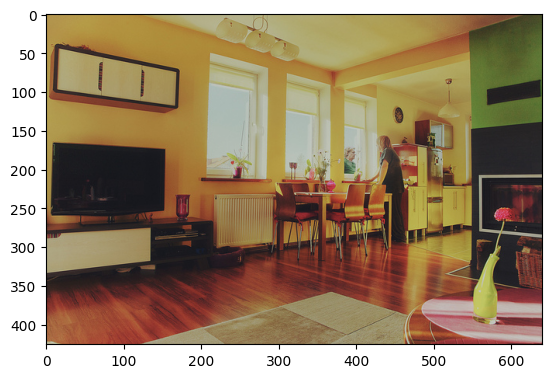

In [ ]:
plt.imshow(image)

## 2.0 Exploratory Data Analysis

In [ ]:
def mean_imputation(image):
    """
    Perform mean imputation of NaN values in a 3-channel RGB image using neighbouring pixels (3x3 neighbourhood).
    
    Args:
        image (torch.Tensor): A 3-channel RGB image with shape (3, height, width).
        
    Returns:
        torch.Tensor: A copy of the input image with NaN values replaced by the mean value of the 3x3 neighbourhood.
    """
    # Create a copy of the input image to avoid modifying the original data
    image_copy = image.float().clone()
    
    # Create a mask of NaN values in the input image
    nan_mask = torch.isnan(image_copy)
    
    # Create a padding of zeros around the input image to handle edge cases
    padded_image = F.pad(image_copy, (1,1,1,1), mode='replicate')
    
    # Compute the mean value of the 3x3 neighbourhood for each NaN value
    nan_mean = F.avg_pool2d(torch.nan_to_num(padded_image), kernel_size=3, stride=1)
    
    # Replace NaN values in the input image with rthe computed mean values
    image_copy[nan_mask] = nan_mean[nan_mask]
    
    return image_copy.to(torch.uint8)

Original image 0:


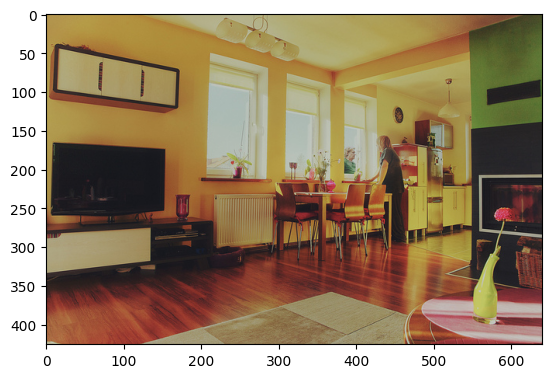

Original image 1000:


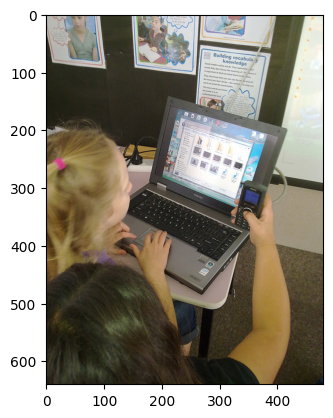

Original image 2000:


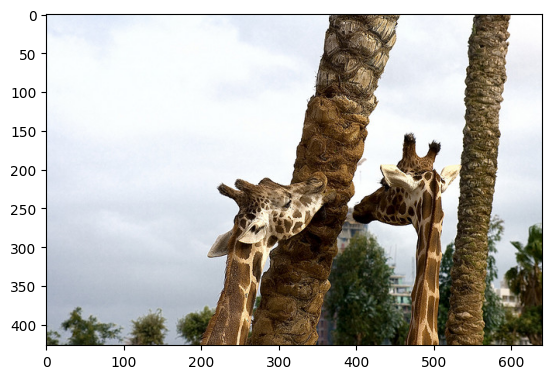

Original image 3000:


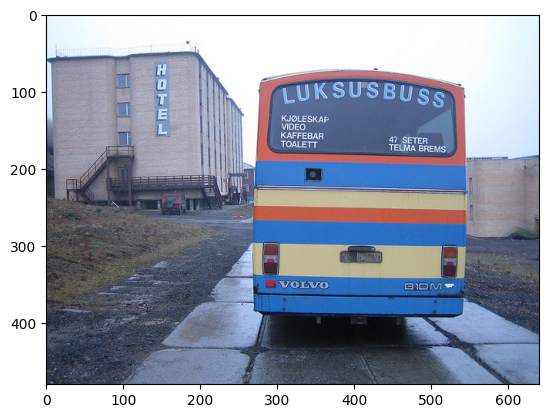

Original image 4000:


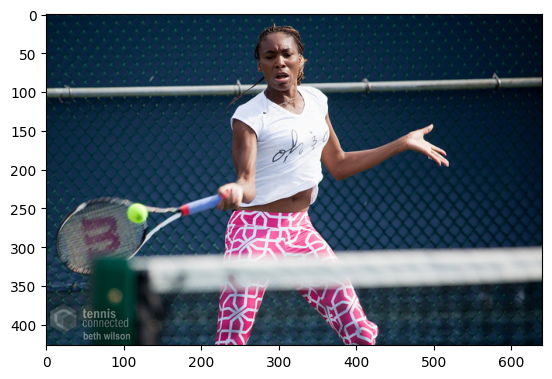

Data Type of Images:  torch.uint8
Shape of first Image:  torch.Size([426, 640, 3])
Number of channels in each image:  3
Minimum Width: 200
Maximum Width: 640
Minimum Height: 145
Maximum Height: 640


In [ ]:
# Create an empty list to store the images
images = []

min_widths = []
max_widths = []
min_heights = []
max_heights = []

# Loop through the directory and open each image using PIL
for i, instance in enumerate(coco):
    image, _ = instance
    image = torch.from_numpy(np.asarray(image))
    # if i>10:
    #   break
    img = image

    # Display a random few images before applying transformations
    if i % 1000 == 0:
        print(f"Original image {i}:")
        plt.imshow(img)
        plt.show()

    height, width = img.size()[:2]
    min_heights.append(height)
    max_heights.append(height)
    min_widths.append(width)
    max_widths.append(width)
    images.append(img)

# Print the data type and shape of the images
print("Data Type of Images: ", images[0].dtype)
print("Shape of first Image: ", images[0].size())
print("Number of channels in each image: ", images[0].size()[-1])

# Print the minimum and maximum width and height of all images in the dataset
print(f"Minimum Width: {min(min_widths)}")
print(f"Maximum Width: {max(max_widths)}")
print(f"Minimum Height: {min(min_heights)}")
print(f"Maximum Height: {max(max_heights)}")

# Convert the images to numpy arrays and stack them together
# image_data = np.stack([np.array(img) for img in images])

In [ ]:
count = 0
for image in images:
    if torch.isnan(image).any():
        count += 1

# print the result
print(f"Number of images with NaN values before mean imputation: {count}")

Number of images with NaN values before mean imputation: 0


In [ ]:
mean_imputed_images = []
for image in images:
    mean_imputed_images.append(mean_imputation(image))

images = mean_imputed_images

In [ ]:
count = 0
for image in images:
    if torch.isnan(image).any():
        count += 1

# print the result
print(f"Number of images with NaN values after mean imputation: {count}")

Number of images with NaN values after mean imputation: 0


In [ ]:
# Calculate the mean, minimum, maximum and range of the images
image_mean = [torch.mean(image.float(), (0, 1)).tolist() for image in images]

image_min = []
image_max = []
for image in images:
    image = torch.flatten(image, start_dim=-2)
    min_values, _ = torch.min(image, dim=1)
    max_values, _ = torch.max(image, dim=1)
    image_min.append(min_values.tolist())
    image_max.append(max_values.tolist())

In [ ]:
image_mean_r = [sublist[0] for sublist in image_mean]
image_mean_g = [sublist[1] for sublist in image_mean]
image_mean_b = [sublist[2] for sublist in image_mean]

In [ ]:
image_min_r = [sublist[0] for sublist in image_min]
image_min_g = [sublist[1] for sublist in image_min]
image_min_b = [sublist[2] for sublist in image_min]

In [ ]:
image_max_r = [sublist[0] for sublist in image_max]
image_max_g = [sublist[1] for sublist in image_max]
image_max_b = [sublist[2] for sublist in image_max]

In [ ]:
image_range_r = list(np.subtract(image_max_r, image_min_r))
image_range_g = list(np.subtract(image_max_g, image_min_g))
image_range_b = list(np.subtract(image_max_b, image_min_b))

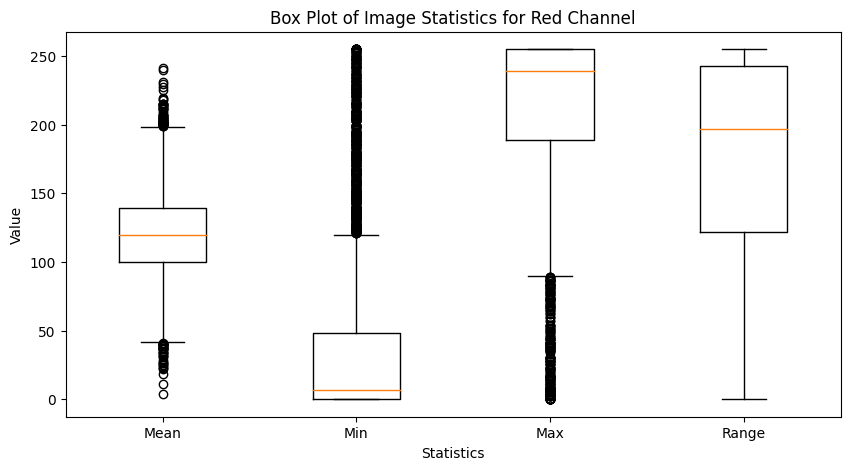

In [ ]:
# Create a box plot for the mean, minimum, maximum and range of the images for the red channel
plt.figure(figsize=(10,5))
plt.boxplot([image_mean_r, image_min_r, image_max_r, image_range_r], labels=['Mean', 'Min', 'Max', 'Range'])
plt.title('Box Plot of Image Statistics for Red Channel')
plt.xlabel('Statistics')
plt.ylabel('Value')
plt.show()

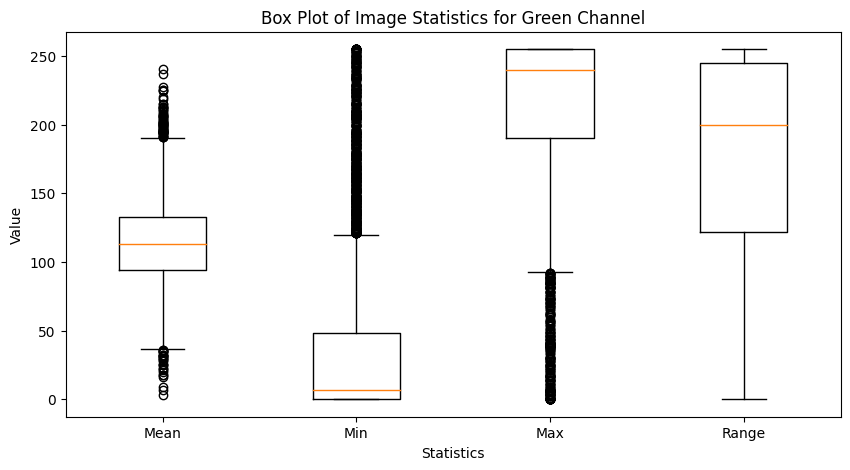

In [ ]:
# Create a box plot for the mean, minimum, maximum and range of the images for the green channel
plt.figure(figsize=(10,5))
plt.boxplot([image_mean_g, image_min_g, image_max_g, image_range_g], labels=['Mean', 'Min', 'Max', 'Range'])
plt.title('Box Plot of Image Statistics for Green Channel')
plt.xlabel('Statistics')
plt.ylabel('Value')
plt.show()

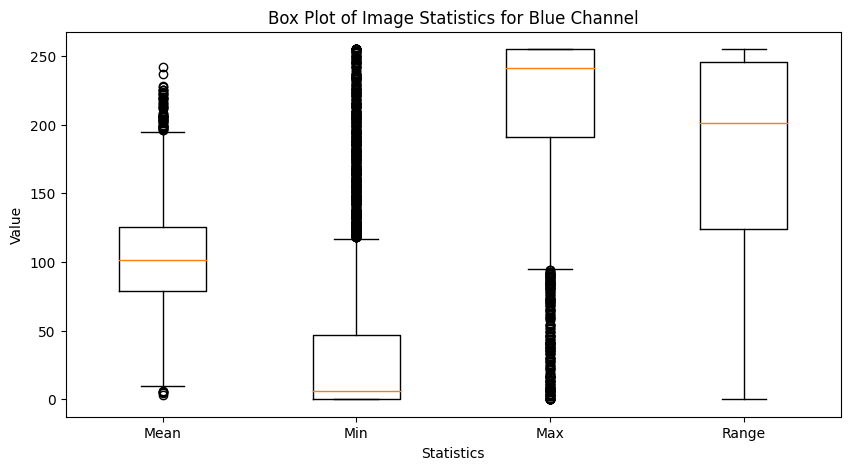

In [ ]:
# Create a box plot for the mean, minimum, maximum and range of the images for the blue channel
plt.figure(figsize=(10,5))
plt.boxplot([image_mean_b, image_min_b, image_max_b, image_range_b], labels=['Mean', 'Min', 'Max', 'Range'])
plt.title('Box Plot of Image Statistics for Blue Channel')
plt.xlabel('Statistics')
plt.ylabel('Value')
plt.show()

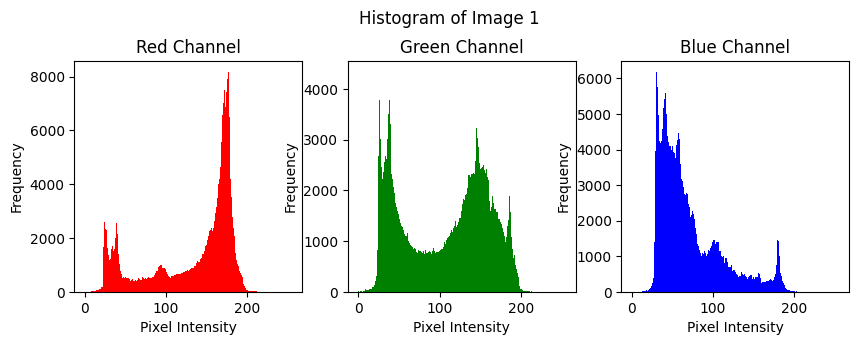

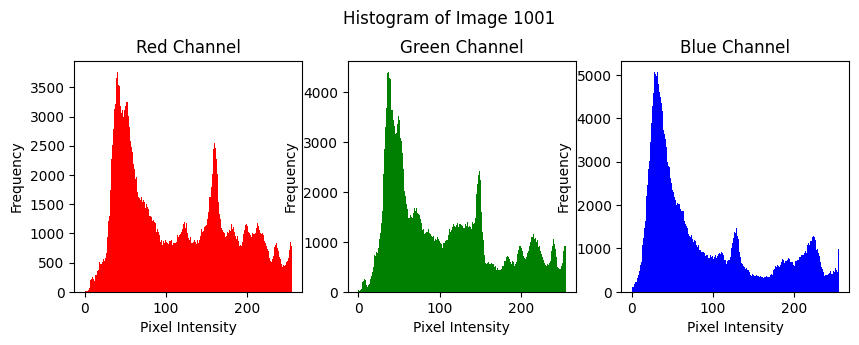

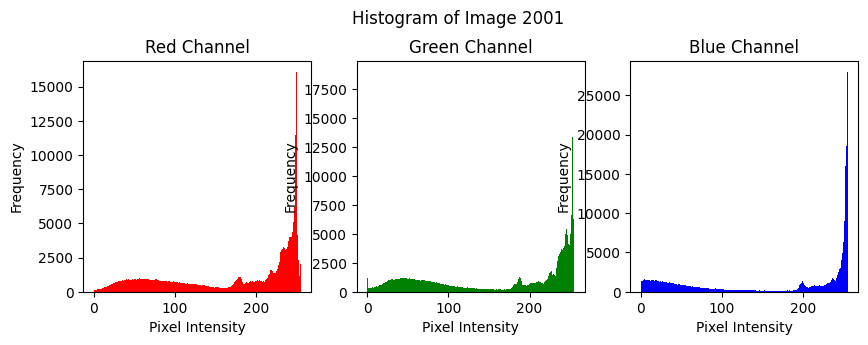

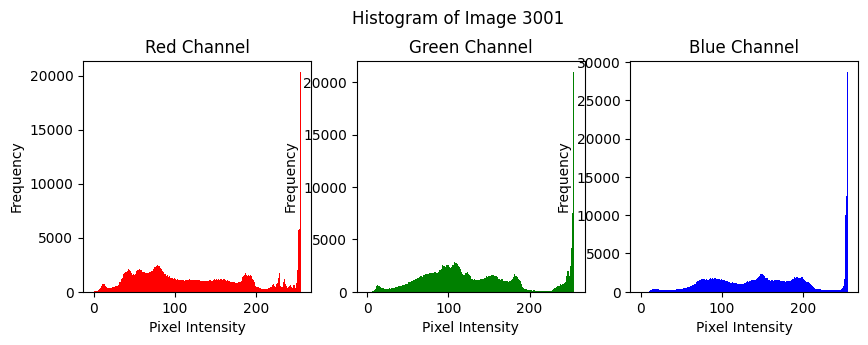

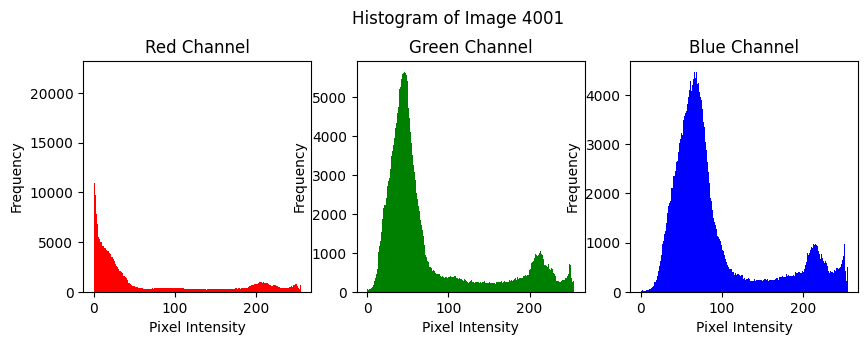

In [ ]:
# Plot a histogram containing 3 subplots (one for each channel) for every 1000th image to check contrast
for i in range(0, len(images), 1000):
    img = images[i]
    img_arr = np.array(img)
    # separate channels
    r, g, b = img_arr[:, :, 0], img_arr[:, :, 1], img_arr[:, :, 2]
    # plot histogram for each channel
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].hist(r.ravel(), bins=256, range=(0, 255), color='red')
    axs[0].set_title('Red Channel')
    axs[0].set_xlabel('Pixel Intensity')
    axs[0].set_ylabel('Frequency')
    axs[1].hist(g.ravel(), bins=256, range=(0, 255), color='green')
    axs[1].set_title('Green Channel')
    axs[1].set_xlabel('Pixel Intensity')
    axs[1].set_ylabel('Frequency')
    axs[2].hist(b.ravel(), bins=256, range=(0, 255), color='blue')
    axs[2].set_title('Blue Channel')
    axs[2].set_xlabel('Pixel Intensity')
    axs[2].set_ylabel('Frequency')
    plt.suptitle(f'Histogram of Image {i+1}', y=1.05)
    plt.show()

In [ ]:
# Define transformations to convert the images to a tensor
transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [ ]:
# Define the function to generate the image pyramid with 2 additional image sizes - original_size//2 and original_size//4
def generate_image_pyramid(image):
    pyramid = [image]
    for i in range(2):
        pyramid.append(torch.nn.functional.avg_pool2d(pyramid[-1], kernel_size=2))
    return pyramid

Image 0: Level 0 size=torch.Size([3, 426, 640])


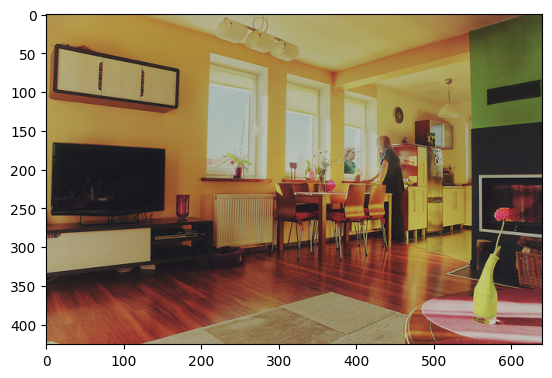

Image 0: Level 1 size=torch.Size([3, 213, 320])


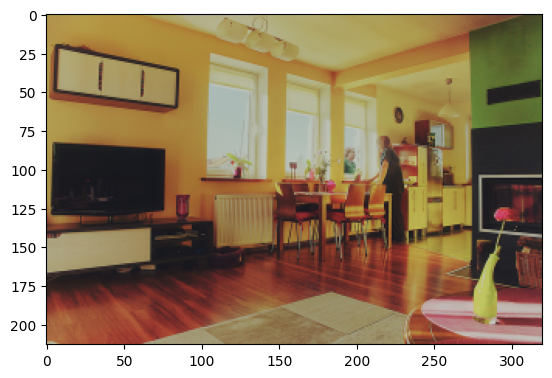

Image 0: Level 2 size=torch.Size([3, 106, 160])


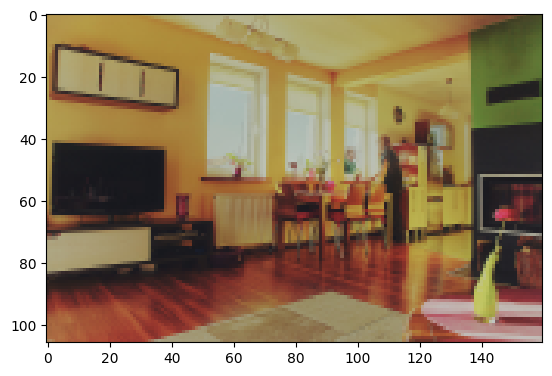

Image 20: Level 0 size=torch.Size([3, 425, 640])


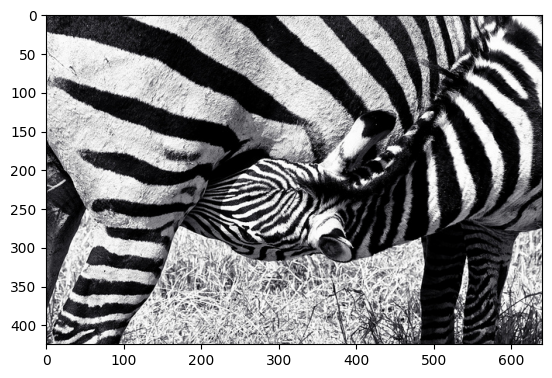

Image 20: Level 1 size=torch.Size([3, 212, 320])


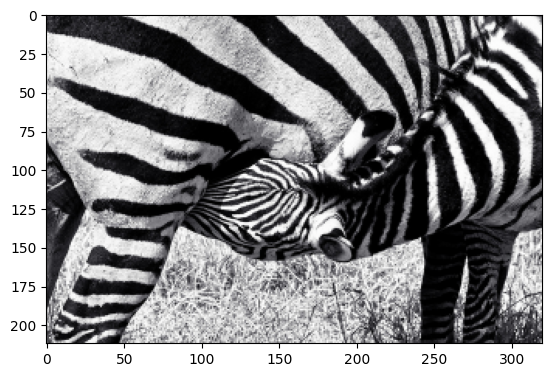

Image 20: Level 2 size=torch.Size([3, 106, 160])


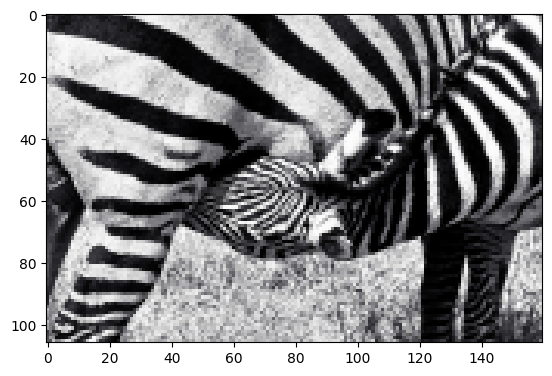

Image 40: Level 0 size=torch.Size([3, 375, 500])


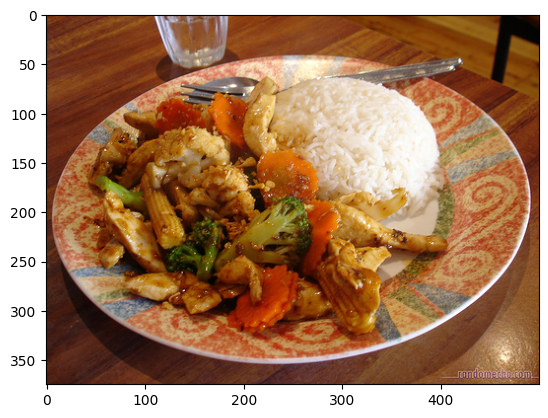

Image 40: Level 1 size=torch.Size([3, 187, 250])


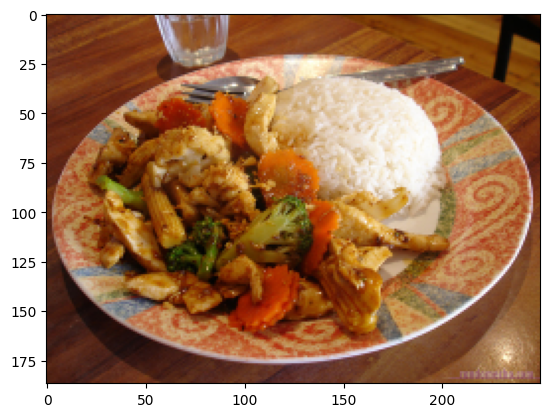

Image 40: Level 2 size=torch.Size([3, 93, 125])


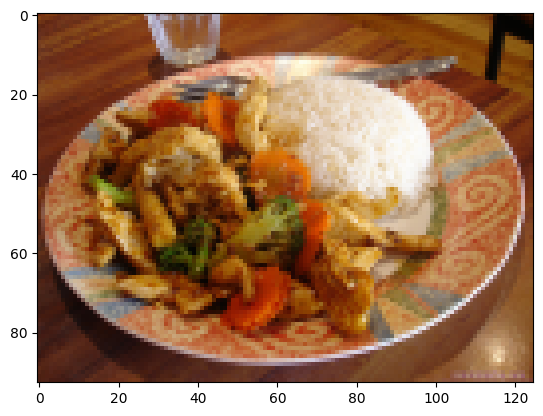

Image 60: Level 0 size=torch.Size([3, 427, 640])


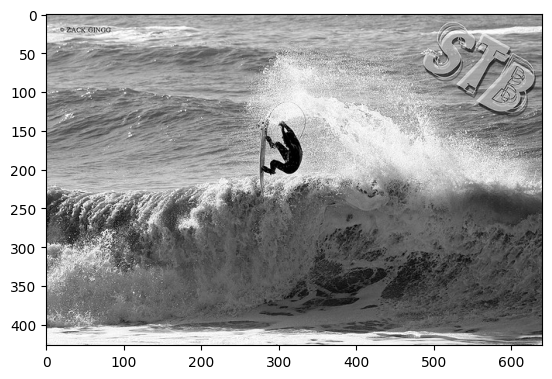

Image 60: Level 1 size=torch.Size([3, 213, 320])


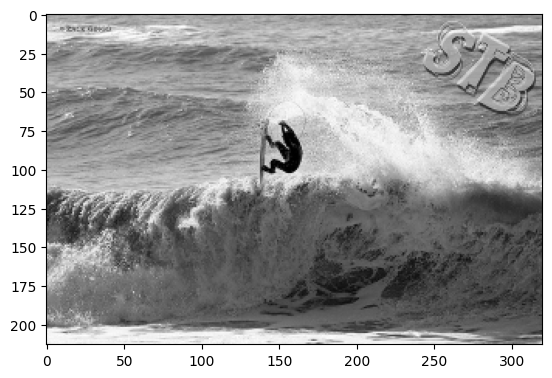

Image 60: Level 2 size=torch.Size([3, 106, 160])


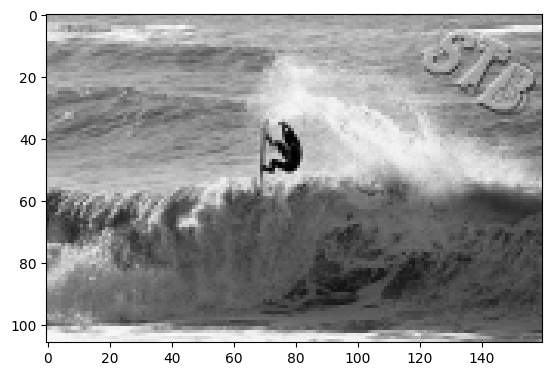

Image 80: Level 0 size=torch.Size([3, 640, 638])


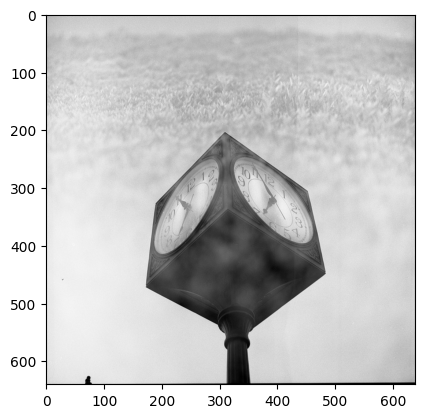

Image 80: Level 1 size=torch.Size([3, 320, 319])


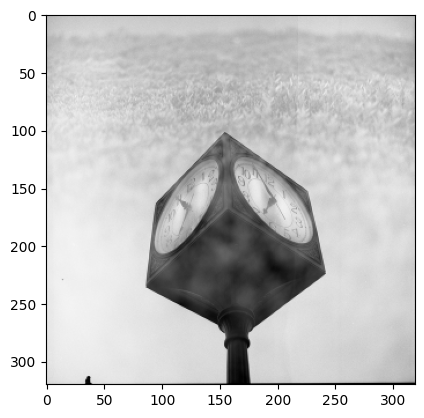

Image 80: Level 2 size=torch.Size([3, 160, 159])


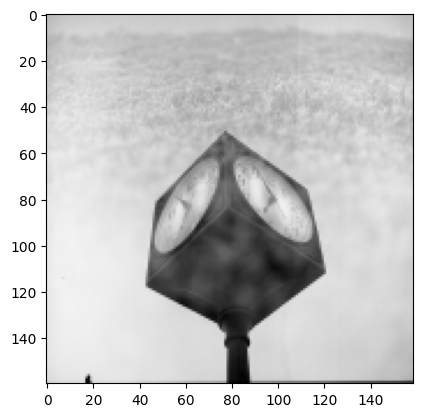

Image 100: Level 0 size=torch.Size([3, 480, 640])


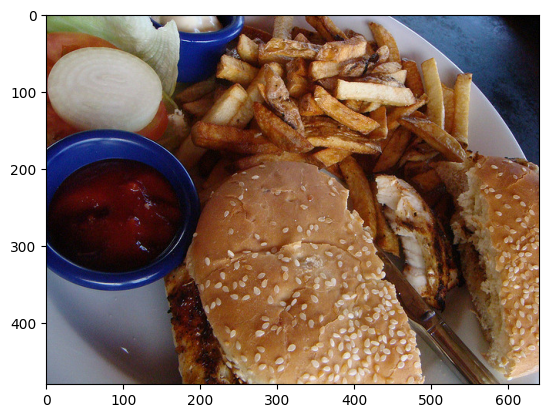

Image 100: Level 1 size=torch.Size([3, 240, 320])


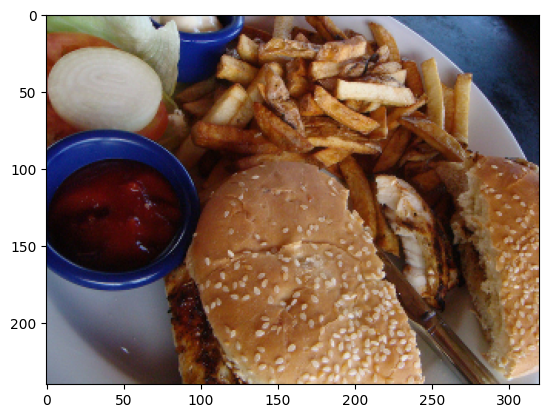

Image 100: Level 2 size=torch.Size([3, 120, 160])


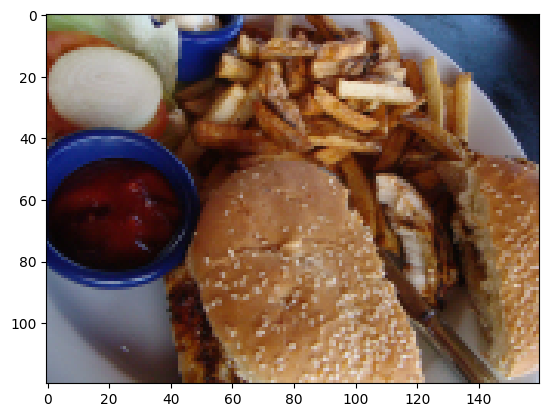

In [ ]:
# Create an empty list to hold the dataset
dataset = []

# Loop through each image
for i, image in enumerate(images):
    # Generate the image pyramid
    pyramid = generate_image_pyramid(transformations(image.permute(2, 0, 1)))

    # Add the original and pyramid images to the dataset
    for j, level in enumerate(pyramid):
        dataset.append(level)
        if i % 2000 == 0:
            print(f"Image {i}: Level {j} size={level.shape}")
            plt.imshow(level.permute(1, 2, 0))
            plt.show()

images = dataset

In [ ]:
# Add gaussian noise to the dataset
for i in range(len(images)):
    noise = torch.randn_like(images[i]) * 0.001
    images[i] += noise

In [ ]:
# Define transformations to normalize/standardize the images across the 3 channels
# Using the mean and std of Imagenet is a common practice.
# They are calculated based on millions of images.
# Using the mean and std of Imagenet is recommended by the computer vision literature.
# However, we're using the default pixel normalization in images, which scales pixel values between 0 and 1. We've found that this configuration works well in practice.
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)
normalize_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
])

In [ ]:
dataset = []
for image in images:
    # apply the transformations
    image = normalize_transformations(image)
    dataset.append(image)

images = dataset

In [ ]:
random_indices = random.sample(range(len(dataset)), 3)
for i in random_indices:
  print(f'Mean values across 3 channels (R, G, B) for image {i} are {dataset[i].mean(dim=(1, 2))}')
  print(f'Standard deviation values across 3 channels (R, G, B) for image {i} are {dataset[i].std(dim=(1, 2))}')

Mean values across 3 channels (R, G, B) for image 88 are tensor([0.3564, 0.4691, 0.6448])
Standard deviation values across 3 channels (R, G, B) for image 88 are tensor([0.2590, 0.2262, 0.2433])
Mean values across 3 channels (R, G, B) for image 21 are tensor([0.4545, 0.4995, 0.4128])
Standard deviation values across 3 channels (R, G, B) for image 21 are tensor([0.3218, 0.2849, 0.2859])
Mean values across 3 channels (R, G, B) for image 103 are tensor([0.4993, 0.5140, 0.4867])
Standard deviation values across 3 channels (R, G, B) for image 103 are tensor([0.1004, 0.1299, 0.2801])


In [ ]:
# transformation to resize images to 64x64
resize_transformation = transforms.Compose([
    transforms.Resize((64, 64))
])

In [ ]:
dataset = []
for image in images:
    dataset.append(resize_transformation(image))

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Size of random image 57 after resizing: torch.Size([64, 64])
Size of random image 102 after resizing: torch.Size([64, 64])
Size of random image 77 after resizing: torch.Size([64, 64])
Size of random image 43 after resizing: torch.Size([64, 64])
Size of random image 113 after resizing: torch.Size([64, 64])


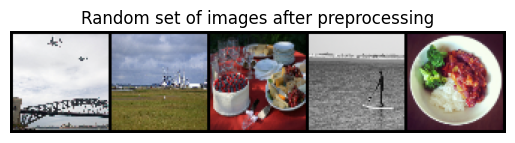

In [ ]:
# Display a random few images from the final dataset after applying transformations
random_indices = random.sample(range(len(dataset)), 5)
random_images = []
for i in random_indices:
    print(f'Size of random image {i} after resizing: {dataset[i].size()[1:]}')
    random_images.append(dataset[i])

# create a grid of images with n rows and 5 columns
grid = make_grid(random_images, nrow=5)

# convert the grid to a numpy array and transpose the axes to (height, width, channels)
grid = grid.permute(1, 2, 0).numpy()

# plot the grid using matplotlib
plt.imshow(grid)
plt.axis('off')
plt.title('Random set of images after preprocessing')
plt.show()

In [ ]:
def plot_correlation(img1, index1, img2, index2):
    # Flatten the images
    img1 = img1.view(-1)
    img2 = img2.view(-1)
    
    # Calculate the correlation between the two images
    corr = np.corrcoef(img1, img2)[0][1]
    
    # Plot the correlation
    plt.scatter(img1, img2, s=1)
    plt.xlabel(f'Pixel Values of Image {index1}')
    plt.ylabel(f'Pixel Values of Image {index2}')
    plt.title('Correlation for two random images: {:.2f}'.format(corr))
    plt.show()

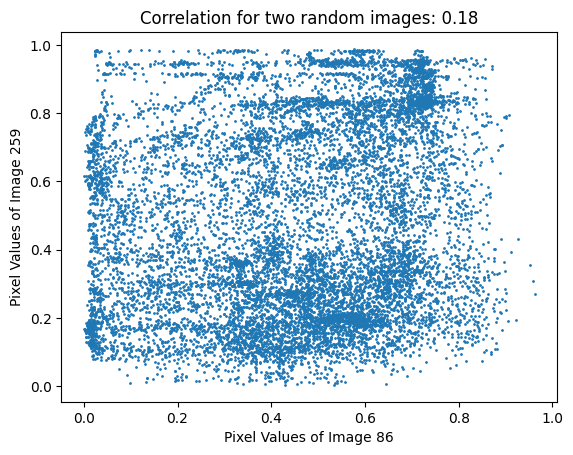

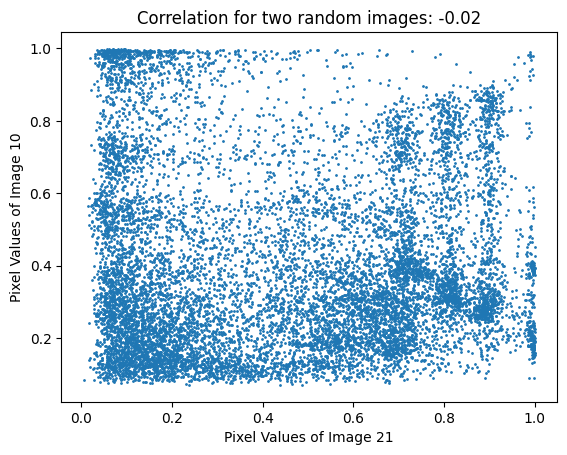

In [ ]:
random_indices = random.sample(range(len(dataset)), 4)
for i in range(0, len(random_indices), 2):
  plot_correlation(dataset[random_indices[i]], random_indices[i], dataset[random_indices[i+1]], random_indices[i+1])

## 3.0 Baseline Implementation

In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("picasso.jpeg")
content_img = image_loader("dancing.jpeg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

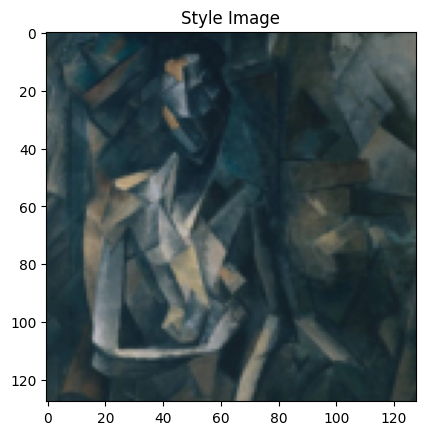

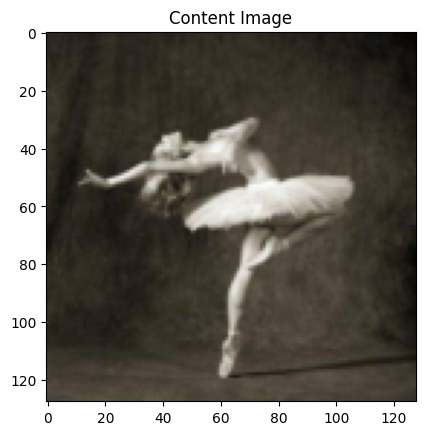

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 58.6MB/s]


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

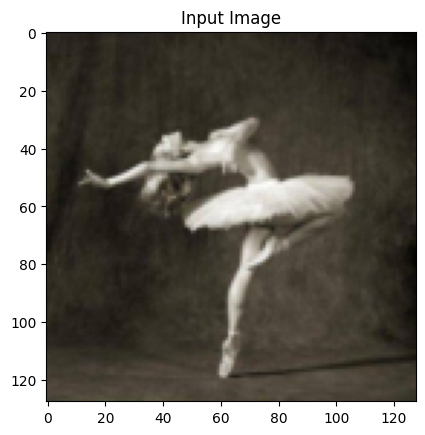

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


<ipython-input-13-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-13-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 98.429321 Content Loss: 17.730108

run [100]:
Style Loss : 23.810619 Content Loss: 16.175709

run [150]:
Style Loss : 9.708190 Content Loss: 14.191810

run [200]:
Style Loss : 5.100715 Content Loss: 12.337824

run [250]:
Style Loss : 3.338744 Content Loss: 10.874058

run [300]:
Style Loss : 2.636498 Content Loss: 9.818277



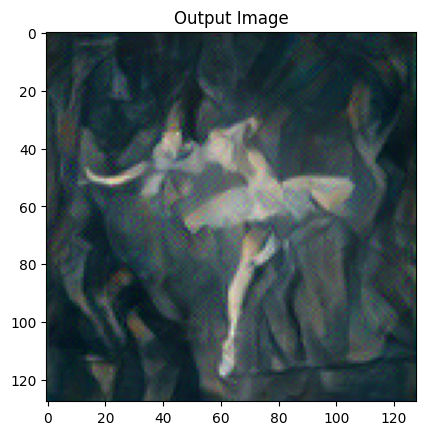

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

# Final Model Implementation

### Script for downloading WikiArt dataset

In [ ]:
# First download the file from https://www.kaggle.com/datasets/antoinegruson/-wikiart-all-images-120k-link
# Read the CSV file
df = pd.read_csv("wikiart_scraped.csv")

# Extract the Link column
links = df["Link"]

# Define the path to the directory to save the images
output_dir = "input/style"

# Create the directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through the links and download the images
for i, link in enumerate(links):       
    filename = f"{i}.jpg"
    filepath = os.path.join(output_dir, filename)
    response = requests.get(link)
    with open(filepath, "wb") as f:
        f.write(response.content)
    print(f"Downloaded image {i+1}/{len(df)}")
    
print("All images downloaded successfully!")

### Method for defining an infinite sampler that generates an infinite stream of indices into a dataset, and a wrapper that can be used to create a PyTorch sampler object from the infinite sampler. Used during training.

In [ ]:
def InfiniteSampler(n):
    # i = 0
    i = n - 1
    order = np.random.permutation(n)
    while True:
        yield order[i]
        i += 1
        if i >= n:
            np.random.seed()
            order = np.random.permutation(n)
            i = 0


class InfiniteSamplerWrapper(data.sampler.Sampler):
    def __init__(self, data_source):
        self.num_samples = len(data_source)

    def __iter__(self):
        return iter(InfiniteSampler(self.num_samples))

    def __len__(self):
        return 2 ** 31

### Methods for computing basic mathematical operations for training and inference

In [ ]:
def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def calc_mean_std1(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    # assert (len(size) == 4)
    WH,N, C = size
    feat_var = feat.var(dim=0) + eps
    feat_std = feat_var.sqrt()
    feat_mean = feat.mean(dim=0)
    return feat_mean, feat_std

def normal(feat, eps=1e-5):
    feat_mean, feat_std= calc_mean_std(feat, eps)
    normalized=(feat-feat_mean)/feat_std
    return normalized

def normal_style(feat, eps=1e-5):
    feat_mean, feat_std= calc_mean_std1(feat, eps)
    normalized=(feat-feat_mean)/feat_std
    return normalized

def _calc_feat_flatten_mean_std(feat):
    # takes 3D feat (C, H, W), return mean and std of array within channels
    assert (feat.size()[0] == 3)
    assert (isinstance(feat, torch.FloatTensor))
    feat_flatten = feat.view(3, -1)
    mean = feat_flatten.mean(dim=-1, keepdim=True)
    std = feat_flatten.std(dim=-1, keepdim=True)
    return feat_flatten, mean, std


def _mat_sqrt(x):
    U, D, V = torch.svd(x)
    return torch.mm(torch.mm(U, D.pow(0.5).diag()), V.t())


def coral(source, target):
    # assume both source and target are 3D array (C, H, W)
    # Note: flatten -> f

    source_f, source_f_mean, source_f_std = _calc_feat_flatten_mean_std(source)
    source_f_norm = (source_f - source_f_mean.expand_as(
        source_f)) / source_f_std.expand_as(source_f)
    source_f_cov_eye = \
        torch.mm(source_f_norm, source_f_norm.t()) + torch.eye(3)

    target_f, target_f_mean, target_f_std = _calc_feat_flatten_mean_std(target)
    target_f_norm = (target_f - target_f_mean.expand_as(
        target_f)) / target_f_std.expand_as(target_f)
    target_f_cov_eye = \
        torch.mm(target_f_norm, target_f_norm.t()) + torch.eye(3)

    source_f_norm_transfer = torch.mm(
        _mat_sqrt(target_f_cov_eye),
        torch.mm(torch.inverse(_mat_sqrt(source_f_cov_eye)),
                 source_f_norm)
    )

    source_f_transfer = source_f_norm_transfer * \
                        target_f_std.expand_as(source_f_norm) + \
                        target_f_mean.expand_as(source_f_norm)

    return source_f_transfer.view(source.size())

### Misc functions, including distributed helpers. Mostly copy-paste from torchvision references. Used in building the model architecture and training of the model.

In [ ]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def get_sha():
    cwd = os.path.dirname(os.path.abspath(__file__))

    def _run(command):
        return subprocess.check_output(command, cwd=cwd).decode('ascii').strip()
    sha = 'N/A'
    diff = "clean"
    branch = 'N/A'
    try:
        sha = _run(['git', 'rev-parse', 'HEAD'])
        subprocess.check_output(['git', 'diff'], cwd=cwd)
        diff = _run(['git', 'diff-index', 'HEAD'])
        diff = "has uncommited changes" if diff else "clean"
        branch = _run(['git', 'rev-parse', '--abbrev-ref', 'HEAD'])
    except Exception:
        pass
    message = f"sha: {sha}, status: {diff}, branch: {branch}"
    return message


def collate_fn(batch):
    batch = list(zip(*batch))
    batch[0] = nested_tensor_from_tensor_list(batch[0])
    return tuple(batch)


def _max_by_axis(the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes


class NestedTensor(object):
    def __init__(self, tensors, mask: Optional[Tensor]):
        self.tensors = tensors
        self.mask = mask

    def to(self, device):
        # type: (Device) -> NestedTensor # noqa
        cast_tensor = self.tensors.to(device)
        mask = self.mask
        if mask is not None:
            assert mask is not None
            cast_mask = mask.to(device)
        else:
            cast_mask = None
        return NestedTensor(cast_tensor, cast_mask)

    def decompose(self):
        return self.tensors, self.mask

    def __repr__(self):
        return str(self.tensors)


def nested_tensor_from_tensor_list(tensor_list: List[Tensor]):
    if tensor_list[0].ndim == 3:
        if torchvision._is_tracing():
            return _onnx_nested_tensor_from_tensor_list(tensor_list)

        max_size = _max_by_axis([list(img.shape) for img in tensor_list])
        batch_shape = [len(tensor_list)] + max_size
        # print(batch_shape)
        b, c, h, w = batch_shape
        dtype = tensor_list[0].dtype
        device = tensor_list[0].device
        tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
        mask = torch.ones((b, h, w), dtype=torch.bool, device=device)
        for img, pad_img, m in zip(tensor_list, tensor, mask):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
            m[: img.shape[1], :img.shape[2]] = False
    else:
        raise ValueError('not supported')
    return NestedTensor(tensor, mask)


@torch.jit.unused
def _onnx_nested_tensor_from_tensor_list(tensor_list: List[Tensor]) -> NestedTensor:
    max_size = []
    for i in range(tensor_list[0].dim()):
        max_size_i = torch.max(torch.stack([img.shape[i] for img in tensor_list]).to(torch.float32)).to(torch.int64)
        max_size.append(max_size_i)
    max_size = tuple(max_size)
    padded_imgs = []
    padded_masks = []
    for img in tensor_list:
        padding = [(s1 - s2) for s1, s2 in zip(max_size, tuple(img.shape))]
        padded_img = torch.nn.functional.pad(img, (0, padding[2], 0, padding[1], 0, padding[0]))
        padded_imgs.append(padded_img)

        m = torch.zeros_like(img[0], dtype=torch.int, device=img.device)
        padded_mask = torch.nn.functional.pad(m, (0, padding[2], 0, padding[1]), "constant", 1)
        padded_masks.append(padded_mask.to(torch.bool))

    tensor = torch.stack(padded_imgs)
    mask = torch.stack(padded_masks)

    return NestedTensor(tensor, mask=mask)


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)


@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    if target.numel() == 0:
        return [torch.zeros([], device=output.device)]
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def interpolate(input, size=None, scale_factor=None, mode="nearest", align_corners=None):
    if float(torchvision.__version__[:3]) < 0.7:
        if input.numel() > 0:
            return torch.nn.functional.interpolate(
                input, size, scale_factor, mode, align_corners
            )

        output_shape = _output_size(2, input, size, scale_factor)
        output_shape = list(input.shape[:-2]) + list(output_shape)
        return _new_empty_tensor(input, output_shape)
    else:
        return torchvision.ops.misc.interpolate(input, size, scale_factor, mode, align_corners)

### Classes and methods for building different parts of the model architecture including the transformer encoder and decoder blocks.

In [ ]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"

# class for bringing the entire model architecture together
class Transformer(nn.Module):

    def __init__(self, d_model=512, nhead=8, num_encoder_layers=3,
                 num_decoder_layers=3, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False,
                 return_intermediate_dec=False):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation, normalize_before)
        encoder_norm = nn.LayerNorm(d_model) if normalize_before else None
        self.encoder_c = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)
        self.encoder_s = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation, normalize_before)
        decoder_norm = nn.LayerNorm(d_model)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm,
                                          return_intermediate=return_intermediate_dec)

        self._reset_parameters()

        self.d_model = d_model
        self.nhead = nhead

        self.new_ps = nn.Conv2d(512 , 512 , (1,1))
        self.averagepooling = nn.AdaptiveAvgPool2d(18)

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, style, mask , content, pos_embed_c, pos_embed_s):

        # content-aware positional embedding
        content_pool = self.averagepooling(content)       
        pos_c = self.new_ps(content_pool)
        pos_embed_c = F.interpolate(pos_c, mode='bilinear',size= style.shape[-2:])

        ###flatten NxCxHxW to HWxNxC     
        style = style.flatten(2).permute(2, 0, 1)
        if pos_embed_s is not None:
            pos_embed_s = pos_embed_s.flatten(2).permute(2, 0, 1)
      
        content = content.flatten(2).permute(2, 0, 1)
        if pos_embed_c is not None:
            pos_embed_c = pos_embed_c.flatten(2).permute(2, 0, 1)
     
        
        style = self.encoder_s(style, src_key_padding_mask=mask, pos=pos_embed_s)
        content = self.encoder_c(content, src_key_padding_mask=mask, pos=pos_embed_c)
        hs = self.decoder(content, style, memory_key_padding_mask=mask,
                          pos=pos_embed_s, query_pos=pos_embed_c)[0]
        
        ### HWxNxC to NxCxHxW to
        N, B, C= hs.shape          
        H = int(np.sqrt(N))
        hs = hs.permute(1, 2, 0)
        hs = hs.view(B, C, -1,H)

        return hs


class TransformerEncoder(nn.Module):

    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src,
                mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        output = src
        
        for layer in self.layers:
            output = layer(output, src_mask=mask,
                           src_key_padding_mask=src_key_padding_mask, pos=pos)

        if self.norm is not None:
            output = self.norm(output)

        return output


class TransformerDecoder(nn.Module):

    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.return_intermediate = return_intermediate

    def forward(self, tgt, memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                query_pos: Optional[Tensor] = None):
        output = tgt

        intermediate = []

        for layer in self.layers:
            output = layer(output, memory, tgt_mask=tgt_mask,
                           memory_mask=memory_mask,
                           tgt_key_padding_mask=tgt_key_padding_mask,
                           memory_key_padding_mask=memory_key_padding_mask,
                           pos=pos, query_pos=query_pos)
            if self.return_intermediate:
                intermediate.append(self.norm(output))

        if self.norm is not None:
            output = self.norm(output)
            if self.return_intermediate:
                intermediate.pop()
                intermediate.append(output)

        if self.return_intermediate:
            return torch.stack(intermediate)

        return output.unsqueeze(0)


class TransformerEncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward_post(self,
                     src,
                     src_mask: Optional[Tensor] = None,
                     src_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None):
        q = k = self.with_pos_embed(src, pos)
        # q = k = src
        # print(q.size(),k.size(),src.size())
        src2 = self.self_attn(q, k, value=src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

    def forward_pre(self, src,
                    src_mask: Optional[Tensor] = None,
                    src_key_padding_mask: Optional[Tensor] = None,
                    pos: Optional[Tensor] = None):
        src2 = self.norm1(src)
        q = k = self.with_pos_embed(src2, pos)
        src2 = self.self_attn(q, k, value=src2, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src2 = self.norm2(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
        src = src + self.dropout2(src2)
        return src

    def forward(self, src,
                src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        if self.normalize_before:
            return self.forward_pre(src, src_mask, src_key_padding_mask, pos)
        return self.forward_post(src, src_mask, src_key_padding_mask, pos)


class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False):
        super().__init__()
        # d_model embedding dim
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward_post(self, tgt, memory,
                     tgt_mask: Optional[Tensor] = None,
                     memory_mask: Optional[Tensor] = None,
                     tgt_key_padding_mask: Optional[Tensor] = None,
                     memory_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None,
                     query_pos: Optional[Tensor] = None):

       
        q = self.with_pos_embed(tgt, query_pos)
        k = self.with_pos_embed(memory, pos)
        v = memory 
 
        tgt2 = self.self_attn(q, k, v, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
    
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt, query_pos),
                                   key=self.with_pos_embed(memory, pos),
                                   value=memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

    def forward_pre(self, tgt, memory,
                    tgt_mask: Optional[Tensor] = None,
                    memory_mask: Optional[Tensor] = None,
                    tgt_key_padding_mask: Optional[Tensor] = None,
                    memory_key_padding_mask: Optional[Tensor] = None,
                    pos: Optional[Tensor] = None,
                    query_pos: Optional[Tensor] = None):
        tgt2 = self.norm1(tgt)
        q = k = self.with_pos_embed(tgt2, query_pos)
        tgt2 = self.self_attn(q, k, value=tgt2, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]

        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.norm2(tgt)
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt2, query_pos),
                                   key=self.with_pos_embed(memory, pos),
                                   value=memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]

        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.norm3(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt2))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt

    def forward(self, tgt, memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                query_pos: Optional[Tensor] = None):
        if self.normalize_before:
            return self.forward_pre(tgt, memory, tgt_mask, memory_mask,
                                    tgt_key_padding_mask, memory_key_padding_mask, pos, query_pos)
        return self.forward_post(tgt, memory, tgt_mask, memory_mask,
                                 tgt_key_padding_mask, memory_key_padding_mask, pos, query_pos)


def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def build_transformer(args):
    return Transformer(
        d_model=args.hidden_dim,
        dropout=args.dropout,
        nhead=args.nheads,
        dim_feedforward=args.dim_feedforward,
        num_encoder_layers=args.enc_layers,
        num_decoder_layers=args.dec_layers,
        normalize_before=args.pre_norm,
        return_intermediate_dec=True,
    )


def _get_activation_fn(activation):
    """Return an activation function given a string"""
    if activation == "relu":
        return F.relu
    if activation == "gelu":
        return F.gelu
    if activation == "glu":
        return F.glu
    raise RuntimeError(F"activation should be relu/gelu, not {activation}.")

### Classes and methods for bringing the entire model together including architecture and loss

In [ ]:
class PatchEmbed(nn.Module):
    """ Method for converting image to Patch Embedding (patches) for the seq2seq task
    """
    def __init__(self, img_size=256, patch_size=8, in_chans=3, embed_dim=512):
        super().__init__()
        to_2tuple = self._ntuple(2)
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)
        return x
    
    # From PyTorch internals
    def _ntuple(self, n):
        def parse(x):
            if isinstance(x, container_abcs.Iterable):
                return x
            return tuple(repeat(x, n))
        return parse


# Final decoder after transformer decoder
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)


# vgg network for computing loss
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)


# class for bringing the entire model together including architecture and loss
class StyleTransfer(nn.Module):
    """ This is the style transform transformer module """
    
    def __init__(self,encoder,decoder,PatchEmbed, transformer,args):

        super().__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31])  # relu3_1 -> relu4_1
        self.enc_5 = nn.Sequential(*enc_layers[31:44])  # relu4_1 -> relu5_1
        
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4', 'enc_5']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

        self.mse_loss = nn.MSELoss()
        self.transformer = transformer
        hidden_dim = transformer.d_model       
        self.decode = decoder
        self.embedding = PatchEmbed

    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(5):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    def calc_content_loss(self, input, target):
      assert (input.size() == target.size())
      assert (target.requires_grad is False)
      return self.mse_loss(input, target)

    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + \
               self.mse_loss(input_std, target_std)
    
    def forward(self, samples_c: NestedTensor,samples_s: NestedTensor):
        """ The forward expects a NestedTensor, which consists of:
               - samples.tensor: batched images, of shape [batch_size x 3 x H x W]
               - samples.mask: a binary mask of shape [batch_size x H x W], containing 1 on padded pixels

        """
        content_input = samples_c
        style_input = samples_s
        if isinstance(samples_c, (list, torch.Tensor)):
            samples_c = nested_tensor_from_tensor_list(samples_c)   # support different-sized images padding is used for mask [tensor, mask] 
        if isinstance(samples_s, (list, torch.Tensor)):
            samples_s = nested_tensor_from_tensor_list(samples_s) 
        
        # ### features used to calcate loss 
        content_feats = self.encode_with_intermediate(samples_c.tensors)
        style_feats = self.encode_with_intermediate(samples_s.tensors)

        ### Linear projection
        style = self.embedding(samples_s.tensors)
        content = self.embedding(samples_c.tensors)
        
        # postional embedding is calculated in transformer.py
        pos_s = None
        pos_c = None

        mask = None
        hs = self.transformer(style, mask , content, pos_c, pos_s)   
        Ics = self.decode(hs)

        Ics_feats = self.encode_with_intermediate(Ics)
        loss_c = self.calc_content_loss(normal(Ics_feats[-1]), normal(content_feats[-1]))+self.calc_content_loss(normal(Ics_feats[-2]), normal(content_feats[-2]))
        # Style loss
        loss_s = self.calc_style_loss(Ics_feats[0], style_feats[0])
        for i in range(1, 5):
            loss_s += self.calc_style_loss(Ics_feats[i], style_feats[i])
            
        
        Icc = self.decode(self.transformer(content, mask , content, pos_c, pos_c))
        Iss = self.decode(self.transformer(style, mask , style, pos_s, pos_s))    

        #Identity losses lambda 1    
        loss_lambda1 = self.calc_content_loss(Icc,content_input)+self.calc_content_loss(Iss,style_input)
        
        #Identity losses lambda 2
        Icc_feats=self.encode_with_intermediate(Icc)
        Iss_feats=self.encode_with_intermediate(Iss)
        loss_lambda2 = self.calc_content_loss(Icc_feats[0], content_feats[0])+self.calc_content_loss(Iss_feats[0], style_feats[0])
        for i in range(1, 5):
            loss_lambda2 += self.calc_content_loss(Icc_feats[i], content_feats[i])+self.calc_content_loss(Iss_feats[i], style_feats[i])
        return Ics,  loss_c, loss_s, loss_lambda1, loss_lambda2   #train
        # return Ics    #test 

### Model training script

In [ ]:
# methods for training and saving the model using 4 losses - content loss, style loss using vgg and identity content, style loss

def train_transform():
    transform_list = [
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor()
    ]
    return transforms.Compose(transform_list)


class FlatFolderDataset(data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        print(self.root)
        self.path = os.listdir(self.root)
        if os.path.isdir(os.path.join(self.root,self.path[0])):
            self.paths = []
            for file_name in os.listdir(self.root):
                for file_name1 in os.listdir(os.path.join(self.root,file_name)):
                    self.paths.append(self.root+"/"+file_name+"/"+file_name1)             
        else:
            self.paths = list(Path(self.root).glob('*'))
        self.transform = transform
    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(str(path)).convert('RGB')
        img = self.transform(img)
        return img
    def __len__(self):
        return len(self.paths)
    def name(self):
        return 'FlatFolderDataset'

def adjust_learning_rate(optimizer, iteration_count):
    """Imitating the original implementation"""
    lr = 2e-4 / (1.0 + args.lr_decay * (iteration_count - 1e4))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def warmup_learning_rate(optimizer, iteration_count):
    """Imitating the original implementation"""
    lr = args.lr * 0.1 * (1.0 + 3e-4 * iteration_count)
    # print(lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


parser = argparse.ArgumentParser()
# Basic options
parser.add_argument('--content_dir', default='./datasets/train2014', type=str,   
                    help='Directory path to a batch of content images')
parser.add_argument('--style_dir', default='./datasets/Images', type=str,  #wikiart dataset crawled from https://www.wikiart.org/
                    help='Directory path to a batch of style images')
parser.add_argument('--vgg', type=str, default='./experiments/vgg_normalised.pth')  #run the train.py, download the pretrained vgg checkpoint

# training options
parser.add_argument('--save_dir', default='./experiments',
                    help='Directory to save the model')
parser.add_argument('--log_dir', default='./logs',
                    help='Directory to save the log')
parser.add_argument('--lr', type=float, default=5e-4)
parser.add_argument('--lr_decay', type=float, default=1e-5)
parser.add_argument('--max_iter', type=int, default=160000)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--style_weight', type=float, default=10.0)
parser.add_argument('--content_weight', type=float, default=7.0)
parser.add_argument('--n_threads', type=int, default=16)
parser.add_argument('--save_model_interval', type=int, default=10000)
parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")
parser.add_argument('--hidden_dim', default=512, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
args = parser.parse_args()

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda:0" if USE_CUDA else "cpu")

if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

if not os.path.exists(args.log_dir):
    os.mkdir(args.log_dir)
writer = SummaryWriter(log_dir=args.log_dir)

vgg = Transfer.vgg
vgg.load_state_dict(torch.load(args.vgg))
vgg = nn.Sequential(*list(vgg.children())[:44])

decoder = Transfer.decoder
embedding = Transfer.PatchEmbed()

Trans = transformer.Transformer()
with torch.no_grad():
    network = Transfer.StyleTransfer(vgg,decoder,embedding, Trans,args)
network.train()

network.to(device)
#network = nn.DataParallel(network, device_ids=[0,1])
#network = nn.DataParallel(network, device_ids=[0])
content_tf = train_transform()
style_tf = train_transform()



content_dataset = FlatFolderDataset(args.content_dir, content_tf)
style_dataset = FlatFolderDataset(args.style_dir, style_tf)

content_iter = iter(data.DataLoader(
    content_dataset, batch_size=args.batch_size,
    sampler=InfiniteSamplerWrapper(content_dataset),
    num_workers=args.n_threads))
style_iter = iter(data.DataLoader(
    style_dataset, batch_size=args.batch_size,
    sampler=InfiniteSamplerWrapper(style_dataset),
    num_workers=args.n_threads))
 

optimizer = torch.optim.Adam([
                              {'params': network.transformer.parameters()},
                              {'params': network.decode.parameters()},
                              {'params': network.embedding.parameters()},      
                              ], lr=args.lr)


if not os.path.exists(args.save_dir+"/test"):
    os.makedirs(args.save_dir+"/test")



for i in tqdm(range(args.max_iter)):

    if i < 1e4:
        warmup_learning_rate(optimizer, iteration_count=i)
    else:
        adjust_learning_rate(optimizer, iteration_count=i)

    # print('learning_rate: %s' % str(optimizer.param_groups[0]['lr']))
    content_images = next(content_iter).to(device)
    style_images = next(style_iter).to(device)  
    out, loss_c, loss_s,l_identity1, l_identity2 = network(content_images, style_images)

    if i % 100 == 0:
        output_name = '{:s}/test/{:s}{:s}'.format(
                        args.save_dir, str(i),".jpg"
                    )
        out = torch.cat((content_images,out),0)
        out = torch.cat((style_images,out),0)
        save_image(out, output_name)

        
    loss_c = args.content_weight * loss_c
    loss_s = args.style_weight * loss_s
    loss = loss_c + loss_s + (l_identity1 * 70) + (l_identity2 * 1) 
  
    print(loss.sum().cpu().detach().numpy(),"-content:",loss_c.sum().cpu().detach().numpy(),"-style:",loss_s.sum().cpu().detach().numpy()
              ,"-l1:",l_identity1.sum().cpu().detach().numpy(),"-l2:",l_identity2.sum().cpu().detach().numpy()
              )
       
    optimizer.zero_grad()
    loss.sum().backward()
    optimizer.step()

    writer.add_scalar('loss_content', loss_c.sum().item(), i + 1)
    writer.add_scalar('loss_style', loss_s.sum().item(), i + 1)
    writer.add_scalar('loss_identity1', l_identity1.sum().item(), i + 1)
    writer.add_scalar('loss_identity2', l_identity2.sum().item(), i + 1)
    writer.add_scalar('total_loss', loss.sum().item(), i + 1)

    if (i + 1) % args.save_model_interval == 0 or (i + 1) == args.max_iter:
        state_dict = network.module.transformer.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].to(torch.device('cpu'))
        torch.save(state_dict,
                   '{:s}/transformer_iter_{:d}.pth'.format(args.save_dir,
                                                           i + 1))

        state_dict = network.module.decode.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].to(torch.device('cpu'))
        torch.save(state_dict,
                   '{:s}/decoder_iter_{:d}.pth'.format(args.save_dir,
                                                           i + 1))
        state_dict = network.module.embedding.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].to(torch.device('cpu'))
        torch.save(state_dict,
                   '{:s}/embedding_iter_{:d}.pth'.format(args.save_dir,
                                                           i + 1))

                                                    
writer.close()




### Model testing script

In [ ]:
# file for using the trained model for inference

def test_transform(size, crop):
    transform_list = []
   
    if size != 0: 
        transform_list.append(transforms.Resize(size))
    if crop:
        transform_list.append(transforms.CenterCrop(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

def style_transform(h,w):
    k = (h,w)
    size = int(np.max(k))
    print(type(size))
    transform_list = []    
    transform_list.append(transforms.CenterCrop((h,w)))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

def content_transform():
    transform_list = []   
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform
  

parser = argparse.ArgumentParser()
# Basic options
parser.add_argument('--content', type=str,
                    help='File path to the content image')
parser.add_argument('--content_dir', type=str,
                    help='Directory path to a batch of content images')
parser.add_argument('--style', type=str,
                    help='File path to the style image, or multiple style \
                    images separated by commas if you want to do style \
                    interpolation or spatial control')
parser.add_argument('--style_dir', type=str,
                    help='Directory path to a batch of style images')
parser.add_argument('--output', type=str, default='output',
                    help='Directory to save the output image(s)')
parser.add_argument('--vgg', type=str, default='./experiments/vgg_normalised.pth')
parser.add_argument('--decoder_path', type=str, default='experiments/decoder_iter_160000.pth')
parser.add_argument('--Trans_path', type=str, default='experiments/transformer_iter_160000.pth')
parser.add_argument('--embedding_path', type=str, default='experiments/embedding_iter_160000.pth')


parser.add_argument('--style_interpolation_weights', type=str, default="")
parser.add_argument('--a', type=float, default=1.0)
parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")
parser.add_argument('--hidden_dim', default=512, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
args = parser.parse_args()




# Advanced options
content_size=512
style_size=512
crop='store_true'
save_ext='.jpg'
output_path=args.output
preserve_color='store_true'
alpha=args.a




device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Either --content or --content_dir should be given.
if args.content:
    content_paths = [Path(args.content)]
else:
    content_dir = Path(args.content_dir)
    content_paths = [f for f in content_dir.glob('*')]

# Either --style or --style_dir should be given.
if args.style:
    style_paths = [Path(args.style)]    
else:
    style_dir = Path(args.style_dir)
    style_paths = [f for f in style_dir.glob('*')]

if not os.path.exists(output_path):
    os.mkdir(output_path)


vgg = Transfer.vgg
vgg.load_state_dict(torch.load(args.vgg))
vgg = nn.Sequential(*list(vgg.children())[:44])

decoder = Transfer.decoder
Trans = transformer.Transformer()
embedding = Transfer.PatchEmbed()

decoder.eval()
Trans.eval()
vgg.eval()
from collections import OrderedDict
new_state_dict = OrderedDict()
state_dict = torch.load(args.decoder_path)
for k, v in state_dict.items():
    namekey = k
    new_state_dict[namekey] = v
decoder.load_state_dict(new_state_dict)

new_state_dict = OrderedDict()
state_dict = torch.load(args.Trans_path)
for k, v in state_dict.items():
    namekey = k
    new_state_dict[namekey] = v
Trans.load_state_dict(new_state_dict)

new_state_dict = OrderedDict()
state_dict = torch.load(args.embedding_path)
for k, v in state_dict.items():
    namekey = k
    new_state_dict[namekey] = v
embedding.load_state_dict(new_state_dict)

network = Transfer.StyleTransfer(vgg,decoder,embedding,Trans,args)
network.eval()
network.to(device)



content_tf = test_transform(content_size, crop)
style_tf = test_transform(style_size, crop)

for content_path in content_paths:
    for style_path in style_paths:
        print(content_path)
       
      
        content_tf1 = content_transform()       
        content = content_tf(Image.open(content_path).convert("RGB"))

        h,w,c=np.shape(content)    
        style_tf1 = style_transform(h,w)
        style = style_tf(Image.open(style_path).convert("RGB"))

      
        style = style.to(device).unsqueeze(0)
        content = content.to(device).unsqueeze(0)
        
        with torch.no_grad():
            output= network(content,style)       
        #output = output.cpu()
        output = output[0]
        print(output[0])
                
        output_name = '{:s}/{:s}_stylized_{:s}{:s}'.format(
            output_path, splitext(basename(content_path))[0],
            splitext(basename(style_path))[0], save_ext
        )
 
        save_image(output, output_name)
   

